# Exploratory Analysis of Coursera Course Data

**Aim of the Analysis:** To examine which organizations on Coursera deliver the most popular courses and which individual courses stand out as the best, while exploring how course organization, course title, certificate type, difficulty, course student enrolled factor into those outcomes.


## Section 1: Project Setup and Data Acquisition

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

---

## Section 2: Data Loading and Initial Exploration

**Goal:** Load the `coursea_data.csv`, verify that rows and columns are intact. Get an initial look at data types and sample values.

### 2.1 Confirm it loaded correctly

In [2]:
data_path = "../Data/coursea_data.csv"
coursea_df = pd.read_csv(data_path)
coursea_df.head()

,Unnamed: 0,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
0,134,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.7,Beginner,5.3k
1,743,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,COURSE,4.7,Intermediate,17k
2,874,A Crash Course in Data Science,Johns Hopkins University,COURSE,4.5,Mixed,130k
3,413,A Law Student's Toolkit,Yale University,COURSE,4.7,Mixed,91k
4,635,A Life of Happiness and Fulfillment,Indian School of Business,COURSE,4.8,Mixed,320k


In [3]:
coursea_df = coursea_df.rename(columns={'Unnamed: 0': 'course_id'})
coursea_df.tail()

,course_id,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
886,236,Программирование на Python,Mail.Ru Group,SPECIALIZATION,4.5,Intermediate,52k
887,883,Психолингвистика (Psycholinguistics),Saint Petersburg State University,COURSE,4.8,Mixed,21k
888,545,Разработка интерфейсов: вёрстка и JavaScript,E-Learning Development Fund,SPECIALIZATION,4.5,Intermediate,30k
889,875,Русский как иностранный,Saint Petersburg State University,SPECIALIZATION,4.6,Intermediate,9.8k
890,163,Финансовые инструменты для частного инвестора,National Research University Higher School of ...,SPECIALIZATION,4.7,Beginner,38k


### **2.1 Data Loading and Initial Exploration**

**Takeaway:** Data loaded correctly (**891×7**), columns look as expected, and `Unnamed: 0` was renamed to `course_id` for clean indexing.

---

### 2.2 Inspect the Structure

**Goal:** View each column’s data type and non-null count to verify structure and completeness, and get an initial sense of numeric distributions and categorical cardinals.

In [4]:
coursea_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   course_id                 891 non-null    int64  
 1   course_title              891 non-null    object 
 2   course_organization       891 non-null    object 
 3   course_Certificate_type   891 non-null    object 
 4   course_rating             891 non-null    float64
 5   course_difficulty         891 non-null    object 
 6   course_students_enrolled  891 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 48.9+ KB


In [5]:
coursea_df.describe()

,course_id,course_rating
count,891.000000,891.000000
mean,445.000000,4.677329
std,257.353842,0.162225
min,0.000000,3.300000
25%,222.500000,4.600000
50%,445.000000,4.700000
75%,667.500000,4.800000
max,890.000000,5.000000


### **2.2 Inspect the Structure & Summary Statistics**

**Takeaway:** Clean structure confirmed: 891×7, no nulls. `course_rating` spans 3.3-5.0, at this stage only `course_id` and `course_rating` are numeric while the rest (including `course_students_enrolled`) are categorical.

---

## Section 3: Data Cleaning

### 3.1 Check for Missing Values
**Goal:** Identify any missing values in the dataset to ensure completeness.

In [6]:
coursea_df.isnull().sum()

course_id                   0
course_title                0
course_organization         0
course_Certificate_type     0
course_rating               0
course_difficulty           0
course_students_enrolled    0
dtype: int64

In [7]:
print("Total nulls:", coursea_df.isnull().sum().sum())

Total nulls: 0


### **3.1 Check for Missing Values**
**Takeaway:** No missing values were found in any column. <u>The dataset is complete</u>, so no imputation or deletion is required at this stage.

---

### 3.2 Check for Duplicate Rows
**Goal:** Detect exact and partial duplicate records (by full row and by key fields) to ensure each entry represents a unique course.

In [8]:
dup_checks = {
    "Number of exact full row duplicates": None,
    "Number of duplicates by title & organization": [
        "course_title", "course_organization"
    ],
    "Number of duplicates by id + title + organization": [
        "course_id", "course_title", "course_organization"
    ],
}

for label, subset in dup_checks.items():
    mask = coursea_df.duplicated(subset=subset, keep=False)
    count = mask.sum()
    print(f"{label}: {count}")
    if count:
        display(
            coursea_df[mask]
            .sort_values(subset or coursea_df.columns.tolist())
            .head(5)
        )

Number of exact full row duplicates: 0
Number of duplicates by title & organization: 2


,course_id,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
224,756,Developing Your Musicianship,Berklee College of Music,COURSE,4.8,Mixed,41k
225,205,Developing Your Musicianship,Berklee College of Music,SPECIALIZATION,4.8,Beginner,54k


Number of duplicates by id + title + organization: 0


### **3.2 Check for Duplicate Rows**

**Takeaway:**
- No exact full-row duplicates were found.
- Two records share the same `course_title` and `course_organization`, but differ in `course_certificate_type` and `course_difficulty`. These represent distinct offerings (course vs specialization) and should be retained separately.
- No rows are dropped or merged at this stage.

---

### 3.3 Fix Data Types

#### 3.3.1 Convert Text Columns to StringDtype
**Goal:** Ensure text based columns use pandas `StringDtype` rather than the generic `object` type.

In [9]:
coursea_df[
    ['course_Certificate_type', 'course_difficulty']
] = coursea_df[
    ['course_Certificate_type', 'course_difficulty']
].astype('string')

In [10]:
coursea_df[['course_Certificate_type','course_difficulty']].dtypes

course_Certificate_type    string[python]
course_difficulty          string[python]
dtype: object

#### **3.3.1 Convert Text Columns to StringDtype**
**Results:**
- Both `course_certificate_type` and `course_difficulty` are now StringDtype.
---

#### 3.3.2 Ensure course_rating Are Numeric
**Goal:** Convert `course_rating` to `float16` and downcast `course_id` to `uint16`.

In [11]:
coursea_df['course_rating'] = (
    pd.to_numeric(coursea_df['course_rating'], errors='coerce')
      .astype('float16')
)

coursea_df['course_id'] = coursea_df['course_id'].astype('uint16')

print(f"course_rating dtype: {coursea_df['course_rating'].dtype} | course_id dtype: {coursea_df['course_id'].dtype}")

course_rating dtype: float16 | course_id dtype: uint16


#### **3.3.2 Ensure course_rating Are Numeric**

**Takeaway:**
- `course_rating` converted to `float16` and `course_id` downcast `uint16`, with no valid data lost.

---

#### 3.3.3 Clean & Convert course_students_enrolled

**Goal:** Convert the enrollment strings (“5.3k”, “2.5m”) into integer counts and store them as `uint32` for efficient analysis.

In [12]:
s = (
    coursea_df["course_students_enrolled"]
    .astype("string")
    .str.strip()
    .str.lower()
)

clean = s.str.replace(",", "", regex=False)
clean = clean.str.replace(r"[km]$", "", regex=True)

numbers = pd.to_numeric(clean, errors="coerce")
multipliers = (
    s.str.extract(r"([km])$", expand=False)
    .map({"k": 1_000, "m": 1_000_000})
    .fillna(1)
)

coursea_df["course_students_enrolled"] = (
    (numbers * multipliers).astype("uint32")
)

In [13]:
coursea_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   course_id                 891 non-null    uint16 
 1   course_title              891 non-null    object 
 2   course_organization       891 non-null    object 
 3   course_Certificate_type   891 non-null    string 
 4   course_rating             891 non-null    float16
 5   course_difficulty         891 non-null    string 
 6   course_students_enrolled  891 non-null    uint32 
dtypes: float16(1), object(2), string(2), uint16(1), uint32(1)
memory usage: 34.9+ KB


In [14]:
pd.options.display.float_format = '{:,.0f}'.format

coursea_df.describe()

,course_id,course_rating,course_students_enrolled
count,891,891,891
mean,445,5,"90,552"
std,257,0,"181,936"
min,0,3,"1,500"
25%,222,5,"17,500"
50%,445,5,"42,000"
75%,668,5,"99,500"
max,890,5,"3,200,000"


#### **3.3.3 Clean & Convert course_students_enrolled**

**Results:**

- Vectorized the parsing of `course_students_enrolled` (strip commas, expand k/m) and saved the counts as `uint32`.
- Column `course_students_enrolled` now has 891 integer values.
- Overall memory usage dropped from 48.9+ KB to 34.9+ KB, saving ~14 KB.

---

### 3.4 Treating Outliers
**Goal:** Identify extreme values in each numeric feature using the IQR rule (1.5 × IQR beyond Q1/Q3).

In [15]:
num_cols = (
    coursea_df
    .select_dtypes(include="number")
    .drop(columns=["course_id"], errors="ignore")
)

q = num_cols.quantile([0.25, 0.75])
q1, q3 = q.loc[0.25], q.loc[0.75]
iqr = q3 - q1

bounds = pd.DataFrame({
        "lower": q1 - 1.5 * iqr,
        "upper": q3 + 1.5 * iqr,
})

mask = num_cols.lt(bounds["lower"], axis="columns") | num_cols.gt(
    bounds["upper"], axis="columns"
)

outliers = (
    num_cols.where(mask)
    .stack()
    .rename_axis(index=["index", "feature"])
    .reset_index(name="value")
    .join(bounds, on="feature")
    .join(coursea_df[["course_id", "course_title"]], on="index")
    .loc[:, ["course_id", "course_title", "feature", "value", "lower", "upper"]]
)

outliers.index = range(1, len(outliers) + 1)
print(f"Found {len(outliers)} total outlier records:")
display(outliers)

feature_counts = (
    outliers["feature"]
    .value_counts()
    .rename_axis("feature")
    .reset_index(name="outlier_count")
)
feature_counts.index = range(1, len(feature_counts) + 1)

print("\nOutliers count by feature:")
display(feature_counts)

Found 110 total outlier records:


,course_id,course_title,feature,value,lower,upper
1,635,A Life of Happiness and Fulfillment,course_students_enrolled,"320,000","-105,500","222,500"
2,54,AI For Everyone,course_students_enrolled,"350,000","-105,500","222,500"
3,631,AWS Fundamentals: Addressing Security Risk,course_rating,4,4,5
4,63,Academic English: Writing,course_students_enrolled,"540,000","-105,500","222,500"
5,157,Advanced Data Science with IBM,course_students_enrolled,"320,000","-105,500","222,500"
...,...,...,...,...,...,...
106,297,Virtual Teacher,course_rating,4,4,5
107,42,Web Design for Everybody: Basics of Web Develo...,course_students_enrolled,"280,000","-105,500","222,500"
108,88,What is Data Science?,course_students_enrolled,"260,000","-105,500","222,500"
109,213,Write Professional Emails in English,course_students_enrolled,"270,000","-105,500","222,500"



Outliers count by feature:


,feature,outlier_count
1,course_students_enrolled,78
2,course_rating,32


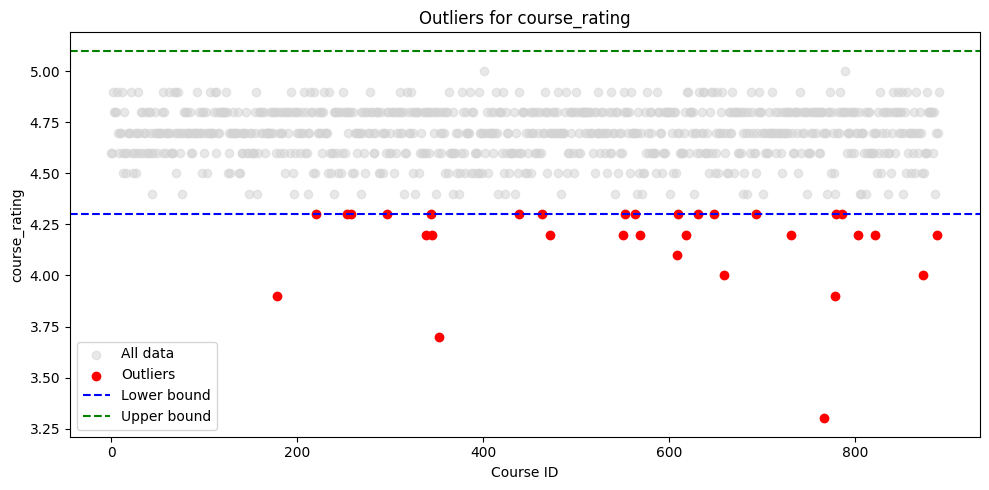

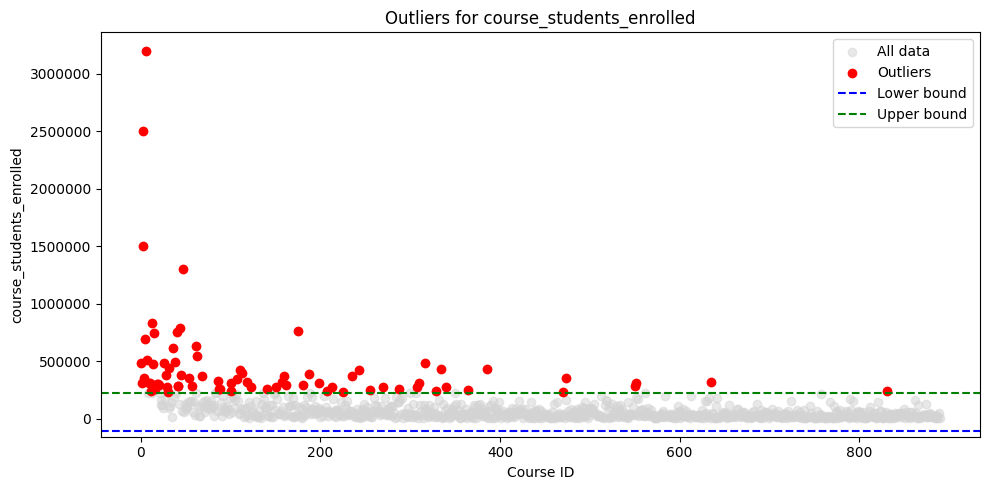

In [16]:
for col in num_cols.columns:
    plt.figure(figsize=(10, 5))
    plt.scatter(
        coursea_df["course_id"],
        coursea_df[col],
        alpha=0.5,
        color="lightgray",
        label="All data"
    )
    out_mask = outliers["feature"] == col
    plt.scatter(
        outliers.loc[out_mask, "course_id"],
        outliers.loc[out_mask, "value"],
        color="red",
        label="Outliers"
    )
    plt.axhline(
        bounds.loc[col, "lower"],
        color="blue",
        linestyle="--",
        label="Lower bound"
    )
    plt.axhline(
        bounds.loc[col, "upper"],
        color="green",
        linestyle="--",
        label="Upper bound"
    )
    plt.title(f"Outliers for {col}")
    plt.xlabel("Course ID")
    plt.ylabel(col)
    plt.legend()
    plt.ticklabel_format(style="plain", axis="y")
    plt.tight_layout()
    plt.show()

### **3.4 Outlier Handling**

**Takeaway:**

* <u>Flagged outliers</u> with 1.5×IQR per numeric column and <u>kept</u> them.
* Found **110** total: **78** in `course_students_enrolled`, **32** in `course_rating`.
* Dataset unchanged, outliers <u>only</u> identified and summarized.
* <u>Likely</u> real extremes (very popular or lower-rated courses), not data errors.

---

## Section 4: Exploratory Data Analysis

### 4.1 Basic Stats & Structure

#### 4.1.1 & 4.1.2 Observation & Features:

**Goal:**
Determine how many observations (rows) and features (columns) are in our dataset.

**1.** How many courses (observations) are in the dataset?

**2.** How many features (columns) does the dataset have?

In [17]:
num_courses, num_features = coursea_df.shape
print(f"Number of courses: {num_courses}")
print(f"Number of features: {num_features}")

Number of courses: 891
Number of features: 7


#### **4.1.1 & 4.1.2 Observation & Features**
- **Takeaway:** The dataset contains <u>891 courses</u> described by <u>7 attributes</u>.

---

#### 4.1.3 & 4.1.4 Categorical & Numeric:

**Goal:**
Identify which columns in the dataset are categorical vs. numeric.

**3.** Which of the features are categorical?

**4.** Which of the features are numeric?

In [18]:
num_cols = num_cols.columns.tolist()
cat_cols = coursea_df.select_dtypes(exclude='number').columns.tolist()

print("Numeric features:", num_cols)
print("Categorical features:", cat_cols)

Numeric features: ['course_rating', 'course_students_enrolled']
Categorical features: ['course_title', 'course_organization', 'course_Certificate_type', 'course_difficulty']


#### **4.1.3 & 4.1.4 Categorical & Numeric**

**Results:**
- **Categorical features (4):** `course_title`, `course_organization`, `course_Certificate_type`, `course_difficulty`.
- **Numeric features (3):** `course_id`, `course_rating`, `course_students_enrolled`.
- **Total features:** 7

---

### 4.2 Inspect Unique Values

#### 4.2.1 Feature Cardinality

**Goal:** Determine the number of unique values in each column.

**5.** How many unique values does each feature have?

In [19]:
unique_counts = coursea_df.nunique().sort_values(ascending=False)
print(unique_counts)

course_id                   891
course_title                888
course_students_enrolled    205
course_organization         154
course_rating                14
course_difficulty             4
course_Certificate_type       3
dtype: int64


#### **4.2.1 Feature Cardinality**

**Takeaway:**
- `course_id` and `course_title` aren't for grouping.
- Treat `course_students_enrolled` and `course_rating` as raw numbers so we can analyze their distributions.
- Since `course_difficulty` and `course_Certificate_type` each have only a few categories, we can plot them directly.
- Because `course_organization` has many unique values, we’ll probably show only the top few organizations.

---

#### 4.2.2 Top 10 Most Frequent Categories

**Goal:** Identify the most common entries (and their counts) for three meaningful categoricals.

**6.** Which are the ten most common entries and their counts for `course_organization`, `course_Certificate_type`, and `course_difficulty`?

In [20]:
cat_cols = [
    "course_organization",
    "course_Certificate_type",
    "course_difficulty",
]

for col in cat_cols:
    n_unique = coursea_df[col].nunique()
    title = (
        f"Top 10 for {col}"
        if n_unique > 10
        else f"Top counts for {col}"
    )
    print(f"\n{title}:")
    print(coursea_df[col].value_counts().head(10))


Top 10 for course_organization:
course_organization
University of Pennsylvania                    59
University of Michigan                        41
Google Cloud                                  34
Duke University                               28
Johns Hopkins University                      28
University of California, Irvine              27
IBM                                           22
University of Illinois at Urbana-Champaign    22
University of California, Davis               21
University of Colorado Boulder                19
Name: count, dtype: int64

Top counts for course_Certificate_type:
course_Certificate_type
COURSE                      582
SPECIALIZATION              297
PROFESSIONAL CERTIFICATE     12
Name: count, dtype: Int64

Top counts for course_difficulty:
course_difficulty
Beginner        487
Intermediate    198
Mixed           187
Advanced         19
Name: count, dtype: Int64


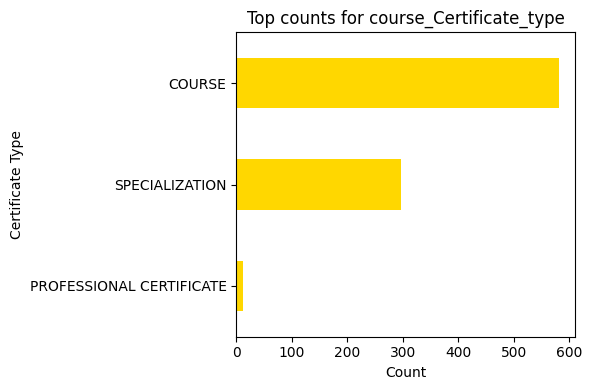

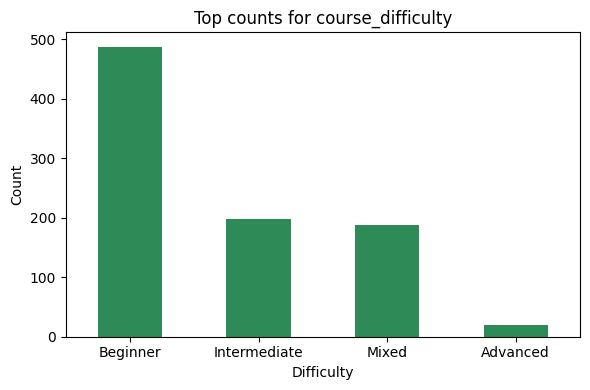

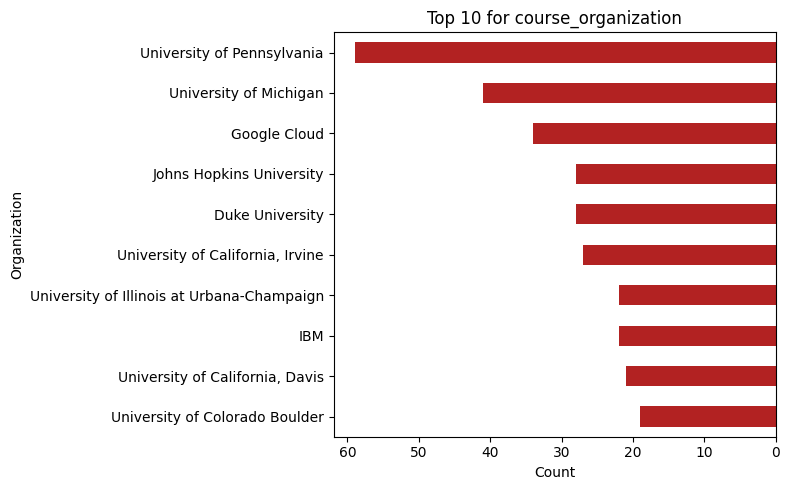

In [21]:
cert_counts = coursea_df["course_Certificate_type"].value_counts()
plt.figure(figsize=(6, 4))
cert_counts.sort_values().plot(kind="barh", color="gold")
plt.title("Top counts for course_Certificate_type")
plt.xlabel("Count")
plt.ylabel("Certificate Type")
plt.tight_layout()
plt.show()

diff_counts = coursea_df["course_difficulty"].value_counts()
plt.figure(figsize=(6, 4))
diff_counts.plot(kind="bar", color="seagreen")
plt.title("Top counts for course_difficulty")
plt.ylabel("Count")
plt.xlabel("Difficulty")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

org_counts = coursea_df["course_organization"].value_counts().head(10)
plt.figure(figsize=(8, 5))
org_counts.sort_values().plot(kind="barh", color="firebrick")
plt.title("Top 10 for course_organization")
plt.xlabel("Count")
plt.ylabel("Organization")
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

#### **4.2.2 Top Levels for Categoricals**

**Results:**

- **Certificate type:**
`COURSE` (65.3%) and `SPECIALIZATION` (33.3%) together account for 98.6% of offerings. `PROFESSIONAL CERTIFICATE` make up only (1.3%).

- **Difficulty distribution:**
Over half the catalog is `Beginner` (54.7%), followed by `Intermediate` (22.2%) and `Mixed` (21.0%), with `Advanced` only 2.1%.

- **Provider Dominance:**
<u>University of Pennsylvania (59)</u> and <u>Michigan (41)</u> alone supply 100 of 891 (11%) courses. With <u>Google Cloud (34)</u>, top three account for 15%. Top ten providers collectively deliver 34% of catalog.

**Insight:**
- Certificates aren’t catching on: Professional certificates are rare. Either students don’t want them, or they take too much effort to create <u>compared to</u> normal courses.
- Lots of easy courses, few hard ones: Coursera is great for beginners, but people who want advanced learning may <u>not find</u> enough options.
- Big names lead the way: Most courses come from a handful of top universities and companies, so learners get what is <u>strongly shaped</u> by those partners.

---

### 4.3 Leading Courses

#### 4.3.1 Providers with Top 5% Courses

**Goal:** Find which organizations contribute the greatest number of courses among the top 5% by enrollment.

**7.** Which providers have the most courses in the top 5% by enrollment?

In [22]:
threshold_95 = coursea_df["course_students_enrolled"].quantile(0.95)
top_5pct = coursea_df[
    coursea_df["course_students_enrolled"] >= threshold_95
]
top_5pct_by_org = top_5pct["course_organization"].value_counts()

print(f"95th percentile enrollment cutoff: {threshold_95} students\n")
print("Number of Top 5% Courses per Provider:\n")
print(top_5pct_by_org)

95th percentile enrollment cutoff: 310000.0 students

Number of Top 5% Courses per Provider:

course_organization
University of Michigan                          7
University of California, Irvine                4
Johns Hopkins University                        4
IBM                                             3
Duke University                                 3
deeplearning.ai                                 3
Yale University                                 2
Google Cloud                                    2
University of Illinois at Urbana-Champaign      2
University of Pennsylvania                      2
Stanford University                             2
Georgia Institute of Technology                 2
Indian School of Business                       1
Pontificia Universidad Católica de Chile        1
Universidad Nacional Autónoma de México         1
Ludwig-Maximilians-Universität München (LMU)    1
Google                                          1
Yonsei University                   

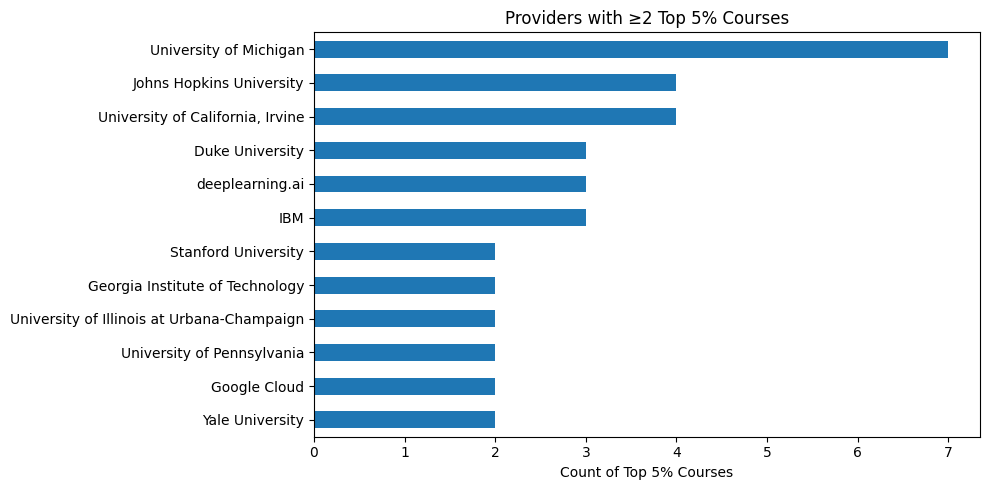

In [23]:
multi_hit = top_5pct_by_org[top_5pct_by_org > 1].sort_values()

plt.figure(figsize=(10, 5))
multi_hit.plot.barh()
plt.title("Providers with ≥2 Top 5% Courses")
plt.xlabel("Count of Top 5% Courses")
plt.ylabel("")
plt.tight_layout()
plt.show()

#### **4.3.1 Providers with Top 5% Courses**

**Results:**
- University of Michigan: 7 courses
- UC Irvine & Johns Hopkins: 4 courses each
- IBM, Duke, deeplearning.ai: 3 courses each
- Stanford, Georgia Tech, UIUC, Pennsylvania, Google Cloud, Yale: 2 courses each

**Insight:**
* <u>Six providers</u> (Michigan, UC Irvine, JHU, IBM, Duke, and deeplearning.ai) <u>produce 48% of all top 5% courses</u>, marking them as the platform’s core content drivers.
* <u>Universities lead the top 3</u>. Five of the six top providers are academic institutions. This underscores university partnerships and suggests we should strengthen collaborations with industry. Help longtail providers replicate their playbooks

---

#### 4.3.2 Providers in Top 5% Courses

**Goal:** Count how many distinct organizations have at least one course in the top 5% by enrollment, reusing our existing `top_5pct_by_org`.

**8.** How many different providers have at least one course in the top 5% by enrollment?

In [24]:
num_providers = top_5pct_by_org.shape[0]

print(f"Number of providers with ≥1 course in the top 5%: {num_providers}")

Number of providers with ≥1 course in the top 5%: 22


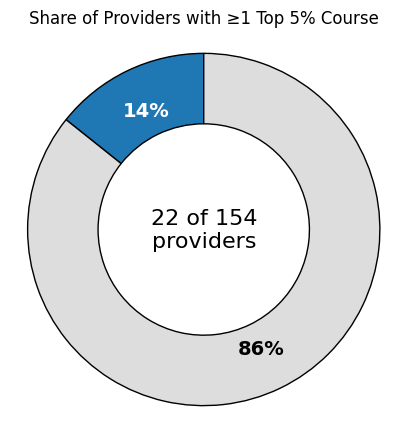

In [25]:
num_hit = top_5pct_by_org.shape[0]
num_miss = coursea_df["course_organization"].nunique() - num_hit

fig, ax = plt.subplots(figsize=(5, 5))
wedges, texts, autotexts = ax.pie(
    [num_hit, num_miss],
    colors=["#1f77b4", "#dddddd"],
    startangle=90,
    wedgeprops=dict(width=0.4, edgecolor="black"),
    autopct="%1.0f%%",
    pctdistance=0.75,
    labeldistance=1.05,
    textprops=dict(weight="bold", fontsize=14),
)
autotexts[0].set_color("white")
autotexts[1].set_color("black")
ax.text(
    0, 0,
    f"{num_hit} of {num_hit + num_miss}\nproviders",
    ha="center",
    va="center",
    fontsize=16,
)
ax.set_title("Share of Providers with ≥1 Top 5% Course", pad=10)
ax.axis("equal")
plt.show()

#### **4.3.2 Providers in Top 5% Courses**

**Results:**

* 22 providers have at least one course in the top 5% by enrollment.
* 132 providers have none.

**Insight:**

* A clear case of the <u>Matthew effect</u>: only 1 in 7 providers has a top-5% course. A <u>few win big while most have none</u>. Many could succeed too if they follow what works.
* Most providers miss the top 5%. Teaching them what works is a big opportunity.

---

#### 4.3.3 Top 5% Courses

**Goal:** List the courses that fall into the top 5% by enrollment.

**9.** Which specific courses rank in the top 5% by enrollment?

In [26]:
top_5pct[[
    "course_title", "course_organization", "course_students_enrolled"
]].sort_values("course_students_enrolled", ascending=False)

,course_title,course_organization,course_students_enrolled
564,Machine Learning,Stanford University,3200000
815,The Science of Well-Being,Yale University,2500000
688,Python for Everybody,University of Michigan,1500000
674,Programming for Everybody (Getting Started wit...,University of Michigan,1300000
196,Data Science,Johns Hopkins University,830000
129,Career Success,"University of California, Irvine",790000
261,English for Career Development,University of Pennsylvania,760000
765,Successful Negotiation: Essential Strategies a...,University of Michigan,750000
199,Data Science: Foundations using R,Johns Hopkins University,740000
211,Deep Learning,deeplearning.ai,690000


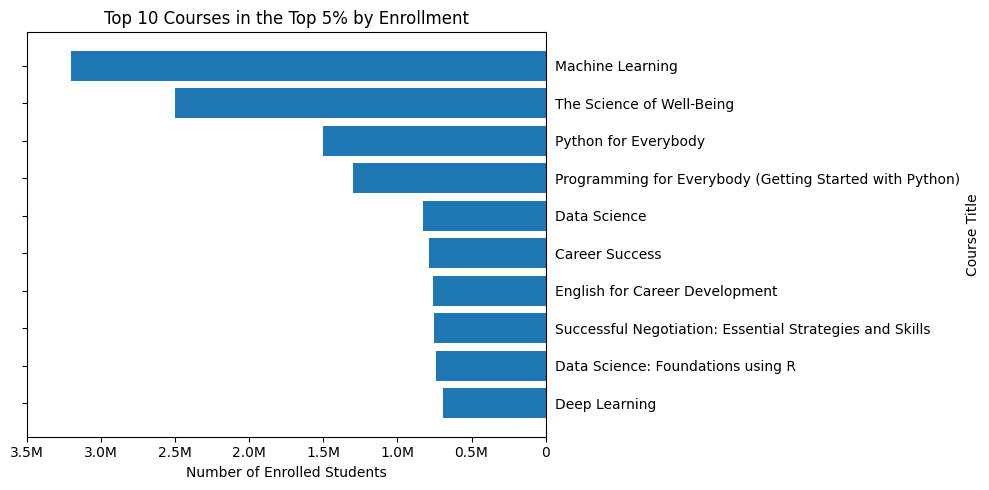

In [27]:
top_10 = top_5pct.nlargest(10, "course_students_enrolled")
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(
    top_10["course_title"][::-1],
    top_10["course_students_enrolled"][::-1],
    color="#1f77b4"
)
ax.invert_xaxis()
ticks = np.arange(0, 3_500_001, 500_000)
labels = ["0" if t == 0 else f"{t/1_000_000:.1f}M"for t in ticks]
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_xlim(3_500_000, 0)
ax.tick_params(axis="y", labelleft=False, labelright=True)
ax.yaxis.set_label_position("right")
ax.set_ylabel("Course Title")
ax.set_xlabel("Number of Enrolled Students")
ax.set_title("Top 10 Courses in the Top 5% by Enrollment")
plt.tight_layout()
plt.show()

#### **4.3.3 Top 5% Courses**

**Results:**

* Cutoff: ≥310,000 students
* Number of courses in top 5%: 50 out of 891
* Top 3 titles:
  1. Machine Learning (Stanford University) - 3,2M
  2. The Science of Well-Being (Yale University) - 2,5M
  3. Python for Everybody (University of Michigan) - 1,5M

**Insight:**

* <u>Enrollment</u> is <u>concentrated</u> in <u>tech skills</u> (ML, Python, Data Science) and <u>soft skills</u> with mass appeal (well-being, career success).
* Top courses come from elite universities and big brands, showing <u>credibility drives scale</u>.
* Offer multi-course pathways that <u>guide learners from fundamentals to advanced topics</u>, instead of standalone one offs, to drive sustained engagement and higher total enrollments.

---

#### 4.3.4 Certificate Types with Top 5% Courses

**Goal:** Identify which certificate types appear at least once among the top 5% by enrollment.

**10.** How many certificate types have at least one course in the top 5% by enrollment?

In [28]:
cert_counts = top_5pct["course_Certificate_type"].value_counts()
cert_counts[cert_counts >= 1]

course_Certificate_type
COURSE                      23
SPECIALIZATION              19
PROFESSIONAL CERTIFICATE     4
Name: count, dtype: Int64

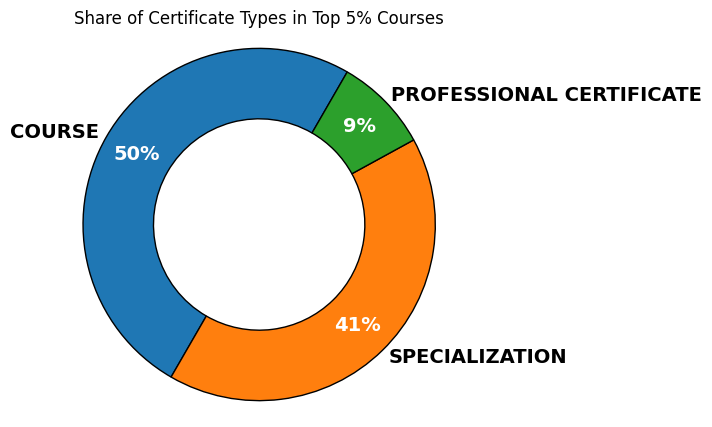

In [29]:
sizes = cert_counts.values
labels = cert_counts.index

fig, ax = plt.subplots(figsize=(5, 5))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct="%1.0f%%",
    startangle=60,
    pctdistance=0.80,
    labeldistance=1.05,
    wedgeprops=dict(width=0.4, edgecolor="black"),
    textprops=dict(color="black", weight="bold", fontsize=14),
)
plt.setp(autotexts, color="white")
ax.set_title("Share of Certificate Types in Top 5% Courses")
ax.axis("equal")
plt.show()

#### **4.3.4 Certificate Types with Top 5% Courses**

**Results:**

* COURSE: 23
* SPECIALIZATION: 19
* PROFESSIONAL CERTIFICATE: 4

**Insight:**

* Standalone courses lead with the highest enrollments. This trend is evident in the rapid growth of massive open online courses.
* Specializations show strong learner demand for structured pathways.
* Professional certificates remain less common in the top tier.

---

### 4.4 Difficulty Breakdown

#### 4.4.1 Distribution of Difficulty Levels

**Goal:** Count how many courses are labeled Beginner, Intermediate, Mixed, or Advanced, and show what percentage of the total each category represents. So we can clearly see how course complexity is distributed across the platform.

**11.** What are the count and percentage of courses in each difficulty category (Beginner, Intermediate, Mixed, Advanced)?

In [30]:
difficulty_counts = coursea_df["course_difficulty"].value_counts()

difficulty_summary = (
    difficulty_counts.rename_axis("Difficulty").reset_index(name="Count")
)
difficulty_summary["Percentage"] = (
    difficulty_summary["Count"]
    / difficulty_summary["Count"].sum()
    * 100
).round(2)
difficulty_summary.index = range(1, len(difficulty_summary) + 1)

display(difficulty_summary)

,Difficulty,Count,Percentage
1,Beginner,487,55
2,Intermediate,198,22
3,Mixed,187,21
4,Advanced,19,2


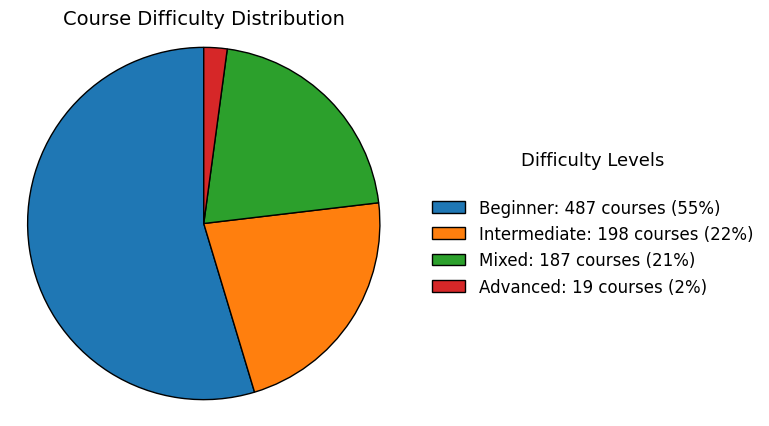

In [31]:
fig, ax = plt.subplots(figsize=(5, 5))

wedges, _ = ax.pie(
    difficulty_summary['Count'],
    startangle=90,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1}
)
legend_labels = [
    f"{row.Difficulty}: {row.Count} courses ({row.Percentage:.0f}%)"
    for _, row in difficulty_summary.iterrows()
]
ax.legend(
    wedges,
    legend_labels,
    title="Difficulty Levels\n",
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    fontsize=12,
    title_fontsize=13,
    frameon=False
)
ax.set_title('Course Difficulty Distribution', fontsize=14, pad=5)
ax.axis('equal')
plt.show()

#### **4.4.1 Distribution of Difficulty Levels**

**Insight:**
* Beginner courses dominate, <u>enrollments</u> mostly <u>come</u> from <u>entry level</u> offerings.
* Advanced courses are only 2%. Revealing a clear <u>gap</u> for learners seeking <u>expert level depth</u>.
* Mixed (21 %) and Intermediate (22 %) courses attract those <u>seeking</u> <u>structured skill growth</u>.

---

#### 4.4.2 Enrollment by Difficulty Level

**Goal:** Analyze how student enrollments vary across difficulty tiers and uncover engagement patterns both platform wide and within top providers.

**12.** How do total and average enrollments differ across Beginner, Intermediate, Mixed, and Advanced courses. Overall and within our leading organizations?

In [32]:
platform_enrollment = (
    coursea_df
    .groupby('course_difficulty')
    .agg(
        total_enrollment=('course_students_enrolled', 'sum'),
        avg_enrollment=('course_students_enrolled', 'mean')
    )
    .reset_index()
)
platform_enrollment.index = range(1, len(platform_enrollment) + 1)
display(platform_enrollment)

top3 = (
    coursea_df.groupby('course_organization')['course_students_enrolled']
    .sum()
    .nlargest(3)
    .index
    .tolist()
)
provider_enrollment = (
    coursea_df[coursea_df['course_organization'].isin(top3)]
    .groupby(['course_organization', 'course_difficulty'])
    .agg(
        total_enrollment=('course_students_enrolled', 'sum'),
        avg_enrollment=('course_students_enrolled', 'mean')
    )
    .reset_index()
)
provider_enrollment.index = range(1, len(provider_enrollment) + 1)
display(provider_enrollment)

,course_difficulty,total_enrollment,avg_enrollment
1,Advanced,1264400,"66,547"
2,Beginner,39921800,"81,975"
3,Intermediate,14506300,"73,264"
4,Mixed,24989400,"133,633"


,course_organization,course_difficulty,total_enrollment,avg_enrollment
1,Stanford University,Advanced,121000,"40,333"
2,Stanford University,Beginner,955000,"119,375"
3,Stanford University,Intermediate,578000,"144,500"
4,Stanford University,Mixed,3200000,"3,200,000"
5,University of Michigan,Beginner,2436900,"128,258"
6,University of Michigan,Intermediate,1302500,"130,250"
7,University of Michigan,Mixed,3698300,"308,192"
8,University of Pennsylvania,Beginner,2483000,"88,679"
9,University of Pennsylvania,Intermediate,53800,"10,760"
10,University of Pennsylvania,Mixed,2964500,"114,019"


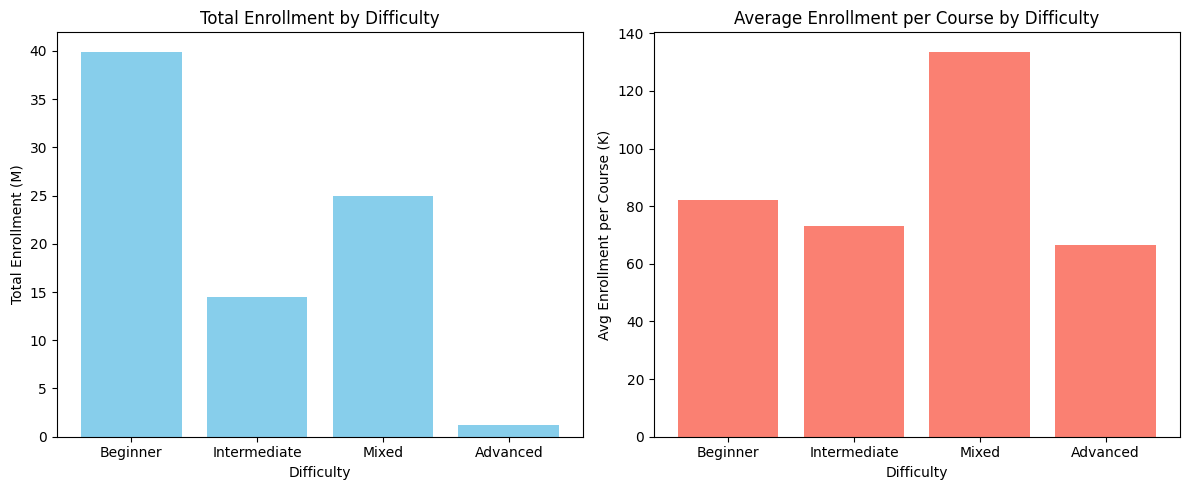

In [33]:
platform_metrics = (
    coursea_df.groupby("course_difficulty")
    .agg(
        total_enrollment=("course_students_enrolled", "sum"),
        avg_enrollment=("course_students_enrolled", "mean"),
    )
    .reset_index()
)

order = ["Beginner", "Intermediate", "Mixed", "Advanced"]
platform_metrics["course_difficulty"] = pd.Categorical(
    platform_metrics["course_difficulty"],
    categories=order,
    ordered=True,
)
platform_metrics = platform_metrics.sort_values("course_difficulty")

platform_metrics["total_M"] = platform_metrics["total_enrollment"] / 1e6
platform_metrics["avg_K"] = platform_metrics["avg_enrollment"] / 1e3

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5), sharex=True)

ax1.bar(
    platform_metrics["course_difficulty"],
    platform_metrics["total_M"],
    color="skyblue",
)
ax1.set_title("Total Enrollment by Difficulty")
ax1.set_xlabel("Difficulty")
ax1.set_ylabel("Total Enrollment (M)")

ax2.bar(
    platform_metrics["course_difficulty"],
    platform_metrics["avg_K"],
    color="salmon",
)
ax2.set_title("Average Enrollment per Course by Difficulty")
ax2.set_xlabel("Difficulty")
ax2.set_ylabel("Avg Enrollment per Course (K)")

plt.tight_layout()
plt.show()

**Results (Platform-Wide)**

Total Enrollments:

* Beginner ≈ 40M
* Intermediate ≈ 14.5M
* Mixed ≈ 25M
* Advanced ≈ 1.3M

Average Enrollments per Course Difficulty:

* Beginner ≈ 82K
* Intermediate ≈ 73K
* Mixed ≈ 134K
* Advanced ≈ 67K

**Results (Top 3 Providers, Avg Enrollment per Course)**
* Stanford University:
Beginner 119 K | Intermediate 145 K | Mixed 3.2 M | Advanced 40 K
* University of Michigan:
Beginner 128 K | Intermediate 130 K | Mixed 308 K | Advanced -
* University of Pennsylvania:
Beginner 89 K | Intermediate 11 K | Mixed 114 K | Advanced -

**Insight:**
* Beginner courses are the biggest driver, about 40M enrollments total.
* Mixed courses have the smallest number of courses presented, but highest average per course, very attractive to learners.
* Intermediate is in the very middle, 14.5M total enrollments and average 73K per course.
* Advanced is very small, 1.3M total enrollments, average 67K per course, leaving room for growth.
* Provider patterns: Stanford dominates in Mixed courses, Michigan performs strongly at all levels, Pennsylvania is weak in Intermediate.

**Takeaway:** Most learners <u>come for Beginner courses</u>, but <u>Mixed-level courses punch above their weight</u>, attracting the <u>most students per course</u>. <u>Advanced content is niche</u>, with <u>room to grow</u>.

---

#### 4.4.3 Top Courses by Difficulty

**Goal:** Identify, for each difficulty tier, the single course that draws the highest total enrollment and the single course that earns the highest learner rating. Along with its issuing organization and certificate type.

**13.** Which courses lead in total enrollments and which lead in average ratings for Beginner, Intermediate, Mixed, and Advanced tiers?

In [34]:
enroll_idx = coursea_df.groupby('course_difficulty')['course_students_enrolled'].idxmax()
enroll_champs = (
    coursea_df
    .loc[enroll_idx, 
         ['course_difficulty',
          'course_title',
          'course_organization',
          'course_Certificate_type',
          'course_students_enrolled']]
    .rename(columns={'course_students_enrolled': 'top_enrollment'})
)
order = ['Beginner', 'Intermediate', 'Mixed', 'Advanced']
enroll_champs['course_difficulty'] = pd.Categorical(
    enroll_champs['course_difficulty'], categories=order, ordered=True
)
enroll_champs = (
    enroll_champs
    .sort_values('course_difficulty')
    .reset_index(drop=True)
)
enroll_champs.index = range(1, len(enroll_champs) + 1)

display(enroll_champs)


rating_idx = coursea_df.groupby('course_difficulty')['course_rating'].idxmax()

rating_champs = (
    coursea_df.loc[
        rating_idx,
        [
            'course_difficulty',
            'course_title',
            'course_organization',
            'course_Certificate_type',
            'course_rating',
        ],
    ]
    .rename(columns={'course_rating': 'top_rating'})
)

rating_champs['course_difficulty'] = pd.Categorical(
    rating_champs['course_difficulty'], categories=order, ordered=True
)
rating_champs = (
    rating_champs.sort_values('course_difficulty').reset_index(drop=True)
)
rating_champs.index = range(1, len(rating_champs) + 1)
display(rating_champs)

,course_difficulty,course_title,course_organization,course_Certificate_type,top_enrollment
1,Beginner,Python for Everybody,University of Michigan,SPECIALIZATION,1500000
2,Intermediate,Deep Learning,deeplearning.ai,SPECIALIZATION,690000
3,Mixed,Machine Learning,Stanford University,COURSE,3200000
4,Advanced,Advanced Data Science with IBM,IBM,SPECIALIZATION,320000


,course_difficulty,course_title,course_organization,course_Certificate_type,top_rating
1,Beginner,El Abogado del Futuro: Legaltech y la Transfor...,Universidad Austral,COURSE,5
2,Intermediate,Infectious Disease Modelling,Imperial College London,SPECIALIZATION,5
3,Mixed,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,COURSE,5
4,Advanced,Medical Neuroscience,Duke University,COURSE,5


#### **4.4.3 Top Courses by Difficulty**

**Insight:**

* Beginner: <u>Scale comes from coding basics.</u> “Python for Everybody” shows that foundational digital skills attract millions, anchoring entry level demand.
* Intermediate: <u>AI dominates, but health stands out.</u> Deep learning drives enrollments, while a health modeling course earns top ratings. Learners want both cutting-edge tech and applied relevance.
* Mixed: <u>Machine Learning is the global flagship.</u> Stanford’s course proves that cross level content sustains mass appeal. The top rated Mixed course is highly niche (Google CBRS), showing quality is recognized in specialized areas.
* Advanced: <u>Specialist fields matter most.</u> Enrollment is smaller, but ratings highlight neuroscience and other deep academic topics as highly valued by learners.

**Takeaway:** <u>Popularity clusters around career critical tech skills</u>, while niche, specialized domains win on satisfaction. Highlighting Coursera’s dual role: <u>scale for the masses and depth for professionals</u>.

---

## Section 5: Summary & Insights

**Aim of the Analysis:** To examine which organizations on Coursera deliver the most popular courses and which individual courses stand out as the best, while exploring how course organization, course title, certificate type, difficulty, course student enrolled factor into those outcomes.

#### **Results**

**Organizations:** Out of 154 providers, 22 had at least one course in the top 5% by enrollment. The University of Michigan (7 courses), UC Irvine (4), Johns Hopkins (4) and Stanford (2) stand out as leaders, alongside a few companies like IBM and deeplearning.ai.

**Courses:** The most popular titles are Machine Learning (Stanford, 3.2M enrollments), The Science of Well-Being (Yale, 2.5M) and Python for Everybody (Michigan, 1.5M).

**Certificate Type:** Top courses are dominated by Courses (23) and Specializations (19). Professional Certificates appear rarely (4).

**Difficulty:** Beginner courses make up over half the catalog and drive 40M enrollments. Mixed courses have the fewest offerings, but the highest average enrollment per course (134K). Advanced courses are only 2% of catalog and niche in reach.

**Enrollment Factor:** Massive enrollment correlates with recognizable universities, career critical tech skills (Python, ML, Data Science) and soft skills (well-being, negotiation).

#### **Insight**
This analysis shows that a <u>small number of elite universities and companies deliver the most popular courses on Coursera</u>, with the University of Michigan, Stanford, Yale, Johns Hopkins, UC Irvine leading by enrollment. The <u>top individual courses</u> are Machine Learning (Stanford, 3.2M enrollments), The Science of Well-Being (Yale, 2.5M) and Python for Everybody (Michigan, 1.5M). <u>Certificate type influences popularity</u>: standalone courses and specializations dominate, while professional certificates are rare. <u>Difficulty also matters</u>: most enrollments come from beginner-level courses, while mixed-level courses attract the highest average enrollment per course and advanced courses remain niche. Overall, course organization, certificate structure, difficulty and brand credibility <u>strongly shape</u> which courses become most successful.

#### **Improvements**

* **Broader Context:** If available, include time data to see enrollment trends across years.
* **Cross Platform Benchmarking:** Compare Coursera’s catalog with edX, Udemy.
* **Regional Insights:** Whether certain providers or topics dominate in specific regions.
* **Engagement Beyond Enrollment:** If rating count data were available, we could measure not just how many sign up, but how many stick around and rate the course.

---